In [2]:
import Bio
import numpy as np
import sys
import os
from tqdm import tqdm # loading bar
from helpers.utils_copy import linear_C, get_cost_2, get_sequence_string, parse_fasta_multiple, create_score_matrix, write_alignments_to_file, linear_backtrack, extend_alignment, Tree, convert_to_desired_format2,convert_format_mat_to_pseudomat,find_min_span_edges,get_visiting_order
from sp_approx_modified import compute_cost, sp_approx
from helpers.utils_copy import nothing,convert_to_desired_format_nr_version


matrix_for_MST=[]

def sp_approxi(seqs: list[str], score_matrix: dict, gap_cost: int, verbose=False, return_center_string=False,layout="spring",traversal_here="df"):
    # STEP 1: Find the center string, s1
    matrix = np.full((len(seqs), len(seqs)), np.nan)
    # loop over all distinct pairs
    for i, seq1 in enumerate(seqs):
        for j, seq2 in enumerate(seqs):
              matrix[i, j] = get_cost_2(linear_C(gap_cost, score_matrix, seq1, seq2))
    print(matrix)
    matrix_for_MST=matrix 
    matrix_for_MST=convert_to_desired_format_nr_version(matrix_for_MST)
    min_span_edges=find_min_span_edges(matrix_for_MST)
    print(matrix_for_MST)
    print(min_span_edges)

    max_indices = np.where(matrix == np.max(matrix))
    max_row_index = max_indices[0][0]
    print(max_row_index)

    visiting_order,G=get_visiting_order(min_span_edges,str(int(max_row_index)),traversal_here,layout) #str(int(np.argmin(matrix.sum(axis = 1)))) to get the min arg as the starting point.
    print(visiting_order) #visiting order is now letters, but we would need that as numbers/idices from the score matrix to keep track. #APPARENTLY NOT ACTUALLY IN USE

    # find center string/guide 
    s1_idx = np.argmin(matrix.sum(axis = 1))
    print("nr of seqs:")
    print(len(seqs))
    #seqs_new = [None for _ in range(len(seqs))]
    #s1 = seqs[s1_idx]
    #seqs_new[0]=seqs[s1_idx]
    #for i,element in enumerate(visiting_order,start=1):
     #       seqs_new[i]=seqs[int(element)]
    seqs_new = [None for _ in range(len(seqs))]
    s1 = seqs[s1_idx] #should be "seqs[s1_idx]", but is set to 2 for testing purposes
    seqs_new[0] = seqs[int(max_row_index)] #should be "seqs[s1_idx]", but is set to 2 for testing purposes
    i=1
    print("new seqs before loop")
    print(seqs_new)
    new_s1_index=None
    for i, idx in enumerate(visiting_order):
        seqs_new[int(idx)] = seqs[i]
        if i==s1_idx:
            new_s1_index=idx
        print("idx:"+str(idx)+", i="+str(i))
    print("new s1-index:")
    print(new_s1_index)
    print("seqs new:")
    print(seqs_new)
    print("old seqs:")
    print(seqs)
    print("matrix for source node inspo:")
    print(matrix)
         
         
    #seqs.insert(0, seqs.pop(s1_idx)) # move guide to front of list
    if verbose: print("The center string, s1, is sequence no." + str(s1_idx+1)) # just a print statement to see which string is the center string

    # STEP 2: Construct alignment M
    M: list[list[str]] = [[letter] for letter in [*seqs[int(max_row_index)]]]
    print("M right now:")
    print(M)
    print("s1 right now:")
    print(s1)
    print("seqs right now")
    print(seqs)
    cost_list = []
    # print("first M = \n" + str(M))
    for i in range(1, len(seqs_new)): #was just seqs bebore
        cost = linear_C(gap_cost, score_matrix, seqs_new[(int(i)-1)], seqs_new[i]) #was just seqs before
        print("\n now aligning...."+str(seqs_new[(int(i)-1)]+ " and "+ str(seqs_new[i])))
        cost_list.append(get_cost_2(cost))
        
        # prepare A-matrix for extension
        alignment1_str, alignment2_str = linear_backtrack(seqs_new[(int(i)-1)], seqs_new[i], cost, score_matrix, gap_cost)
        alignment1, alignment2 = [*alignment1_str], [*alignment2_str]
        A = [list(e) for e in zip(alignment1,alignment2)]
        print("A right now is: "+str(A))
        print("M right now: "+str(M))
        # extend
        Mk = extend_alignment(M, A)
        M = Mk
    
    # ACTUALLY COMPUTE (approximate) COST
    total_cost = compute_cost(M, score_matrix, gap_cost)

    #if return_center_string: return total_cost, M, s1_idx #IDK why this runs for no reason when it's uncommented..
    return total_cost, M, matrix_for_MST, visiting_order,G

[[ 0. 57. 65. 53. 53. 10. 49. 49. 46. 20.]
 [57.  0. 14. 10. 12. 57. 20. 16. 49. 56.]
 [65. 14.  0. 12. 26. 65. 34. 30. 45. 64.]
 [53. 10. 12.  0. 16. 53. 24. 20. 40. 52.]
 [53. 12. 26. 16.  0. 53.  8.  4. 54. 52.]
 [10. 57. 65. 53. 53.  0. 49. 49. 36. 10.]
 [49. 20. 34. 24.  8. 49.  0.  4. 53. 48.]
 [49. 16. 30. 20.  4. 49.  4.  0. 53. 48.]
 [46. 49. 45. 40. 54. 36. 53. 53.  0. 32.]
 [20. 56. 64. 52. 52. 10. 48. 48. 32.  0.]]
[['' '57' '0' '1']
 ['' '65' '0' '2']
 ['' '53' '0' '3']
 ['' '53' '0' '4']
 ['' '10' '0' '5']
 ['' '49' '0' '6']
 ['' '49' '0' '7']
 ['' '46' '0' '8']
 ['' '20' '0' '9']
 ['' '14' '1' '2']
 ['' '10' '1' '3']
 ['' '12' '1' '4']
 ['' '57' '1' '5']
 ['' '20' '1' '6']
 ['' '16' '1' '7']
 ['' '49' '1' '8']
 ['' '56' '1' '9']
 ['' '12' '2' '3']
 ['' '26' '2' '4']
 ['' '65' '2' '5']
 ['' '34' '2' '6']
 ['' '30' '2' '7']
 ['' '45' '2' '8']
 ['' '64' '2' '9']
 ['' '16' '3' '4']
 ['' '53' '3' '5']
 ['' '24' '3' '6']
 ['' '20' '3' '7']
 ['' '40' '3' '8']
 ['' '52' '3' '9']

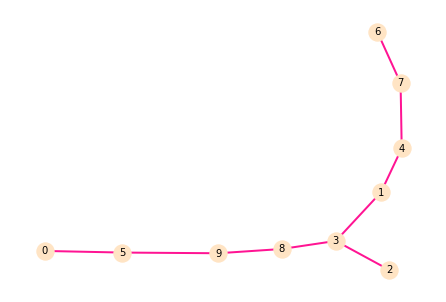

My traversal is df
['0', '5', '9', '8', '3', '1', '4', '7', '6', '2']
nr of seqs:
10
new seqs before loop
['aaaaaaaaa', None, None, None, None, None, None, None, None, None]
idx:0, i=0
idx:5, i=1
idx:9, i=2
idx:8, i=3
idx:3, i=4
idx:1, i=5
idx:4, i=6
idx:7, i=7
idx:6, i=8
idx:2, i=9
new s1-index:
7
seqs new:
['aaaaaaaaa', 'aaaaggggg', 'gggggggg', 'ccctttttttt', 'tttttttttt', 'cccccccctttt', 'gggggggggccccccc', 'cctttttttt', 'ccccccccccc', 'ccccccccccccct']
old seqs:
['aaaaaaaaa', 'cccccccctttt', 'ccccccccccccct', 'ccccccccccc', 'ccctttttttt', 'aaaaggggg', 'tttttttttt', 'cctttttttt', 'gggggggggccccccc', 'gggggggg']
matrix for source node inspo:
[[ 0. 57. 65. 53. 53. 10. 49. 49. 46. 20.]
 [57.  0. 14. 10. 12. 57. 20. 16. 49. 56.]
 [65. 14.  0. 12. 26. 65. 34. 30. 45. 64.]
 [53. 10. 12.  0. 16. 53. 24. 20. 40. 52.]
 [53. 12. 26. 16.  0. 53.  8.  4. 54. 52.]
 [10. 57. 65. 53. 53.  0. 49. 49. 36. 10.]
 [49. 20. 34. 24.  8. 49.  0.  4. 53. 48.]
 [49. 16. 30. 20.  4. 49.  4.  0. 53. 48.]
 [46

In [4]:
seqs=["atc","attc","agt","gga"]
seqss=['gttccgaaaggctagcgctaggcgcc', 'atggatttatctgctcttcg', 'tgcatgctgaaacttctcaacca']
seqsss=['gttccgaaaggctagcgctaggcgcc', 'atggatttatctgctcttcg', 'tgcatgctgaaacttctcaacca', 'cgttgccgggcgagagcgatgccta', 'ttgtgatagccttttcagat', 'taacctagaaagactgtttccgcg']
doc_seqs=sequences = [
    "aaaaaaaaa",
    "cccccccctttt",
    "ccccccccccccct",
    "ccccccccccc",
    "ccctttttttt",
    "aaaaggggg",
    "tttttttttt",
    "cctttttttt",
    "gggggggggccccccc",
    "gggggggg"
]

score_matrix={'a': {'a': 0, 'c': 5, 'g': 2, 't': 5}, 'c': {'a': 5, 'c': 0, 'g': 5, 't': 2}, 'g': {'a': 2, 'c': 5, 'g': 0, 't': 5}, 't': {'a': 5, 'c': 2, 'g': 5, 't': 0}}
gap_cost=4
total_cost_new, M, matrix_for_MST, visiting_order,graph=sp_approxi(doc_seqs,score_matrix,gap_cost,"spring",traversal_here="df")
print("total cost following: ")
print(total_cost_new)
print(M)
print(graph)







In [21]:
import networkx as nx
def my_traversal(graph):
    neighborhood={}
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        neighborhood[node]=neighbors
        print(f"Neighbors of node {node}: {neighbors}")
    print(neighborhood)

    starting_val=0
    traversal_order=[]
    traversal_order.append(starting_val)
    unseen_nodes=[]
    for node in graph.nodes():
        unseen_nodes.append(node)
    print(unseen_nodes)
    we_are_at=[neighborhood[str(starting_val)]]
    print(we_are_at)
    unseen_nodes.pop(starting_val)
    alignment_pairs={}
    parent_node=starting_val

    while len(unseen_nodes)>0:
        connections=neighborhood[we_are_at]
        i=0
        have_put_something=False
        if have_put_something==False and connections[i] in unseen_nodes:
            alignment_pairs[connections[i]]=parent_node
            have_put_something=True
            unseen_nodes.pop(connections[i])
            i+=1
        elif have_put_something==True and connections[i] in unseen_nodes:
            alignment_pairs[connections[i]]=parent_node
        parent_node=we_are_at
        we_are_at=connections[i]



my_traversal(graph)


Neighbors of node 0: ['5']
Neighbors of node 1: ['3', '4']
Neighbors of node 2: ['3']
Neighbors of node 3: ['1', '2', '8']
Neighbors of node 4: ['7', '1']
Neighbors of node 5: ['0', '9']
Neighbors of node 6: ['7']
Neighbors of node 7: ['4', '6']
Neighbors of node 8: ['9', '3']
Neighbors of node 9: ['5', '8']
{'0': ['5'], '1': ['3', '4'], '2': ['3'], '3': ['1', '2', '8'], '4': ['7', '1'], '5': ['0', '9'], '6': ['7'], '7': ['4', '6'], '8': ['9', '3'], '9': ['5', '8']}
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[['5']]


In [50]:
def my_traversal_simple (graph,starting_key):
    neighborhood={}
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        neighborhood[node]=neighbors
        print(f"Neighbors of node {node}: {neighbors}")
    seen_nodes=[]
    #for node in graph.nodes():
     #   unseen_nodes.append(node)
    seen_nodes.append(starting_key)
    alignment_pairs={}
    i=0
    for key,values in neighborhood.items():
        i=0
        if key in seen_nodes: #if a place (value) has not been seen yet, it can be used as the 
            for value in values:
                alignment_pairs[value]=key #
                seen_nodes.append(value)
    print(alignment_pairs)

my_traversal_simple(graph,"0")

Neighbors of node 0: ['5']
Neighbors of node 1: ['3', '4']
Neighbors of node 2: ['3']
Neighbors of node 3: ['1', '2', '8']
Neighbors of node 4: ['7', '1']
Neighbors of node 5: ['0', '9']
Neighbors of node 6: ['7']
Neighbors of node 7: ['4', '6']
Neighbors of node 8: ['9', '3']
Neighbors of node 9: ['5', '8']
{'5': '9', '0': '5', '9': '5', '8': '9'}


In [74]:
def my_traversal_simply(graph, starting_key):
    neighborhood = {}
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        neighborhood[node] = neighbors
        print(f"Neighbors of node {node}: {neighbors}")
    
    alignment_pairs = {}
    queue = [starting_key]  # Initialize the queue with the starting node
    while queue:
        current_node = queue.pop(0)  # Get the first node from the queue
        
        if current_node in neighborhood:
            for successor in neighborhood[current_node]:
                if successor not in alignment_pairs:
                    alignment_pairs[successor] = current_node
                    queue.append(successor)  # Add successor to the queue for further traversal
    if starting_key in alignment_pairs:
        del alignment_pairs[starting_key]
        
    print(alignment_pairs)
    pos_dict={}
    #pos_dict_addition={}
    #pos_dict[starting_key]=0
    #pos_dict_addition={key: str(index+1) for index, key in enumerate(alignment_pairs.values())}
    #print("pos dict: "+str(pos_dict))
    #print("pos dict add: "+str(pos_dict_addition))
    #merged_dict = {**pos_dict, **pos_dict_addition}

    #return(alignment_pairs, merged_dict)
    #pos_dict = {}
    #pos_dict[starting_key] = 0
    #pos_dict.update({key: str(index) for index, key in enumerate(alignment_pairs.values())})
    #return(alignment_pairs,pos_dict)
    index_dict = {}
    index = 0

    # Add starting key with index 0
    starting_key = '0'
    index_dict[starting_key] = str(index)
    index += 1

    # Add values from alignment_pairs with increasing indices
    for key, value in alignment_pairs.items():
        if key not in index_dict:
            index_dict[key] = str(index)
            index += 1
        if value not in index_dict:
            index_dict[value] = str(index)
            index += 1
    return(alignment_pairs,index_dict)

al,pos_dict=my_traversal_simply(graph,"0")
print(al,pos_dict)


Neighbors of node 0: ['5']
Neighbors of node 1: ['3', '4']
Neighbors of node 2: ['3']
Neighbors of node 3: ['1', '2', '8']
Neighbors of node 4: ['7', '1']
Neighbors of node 5: ['0', '9']
Neighbors of node 6: ['7']
Neighbors of node 7: ['4', '6']
Neighbors of node 8: ['9', '3']
Neighbors of node 9: ['5', '8']
{'5': '0', '9': '5', '8': '9', '3': '8', '1': '3', '2': '3', '4': '1', '7': '4', '6': '7'}
{'5': '0', '9': '5', '8': '9', '3': '8', '1': '3', '2': '3', '4': '1', '7': '4', '6': '7'} {'0': '0', '5': '1', '9': '2', '8': '3', '3': '4', '1': '5', '2': '6', '4': '7', '7': '8', '6': '9'}


In [92]:
def extend_alignment_chaos(M,str1_nr,A,position_dictionary):#needs inclusion of str1_nr to come from the outside....
    MA = []
    i = 0
    j = 0
    col_in_M_of_parent_string=int(position_dictionary[str1_nr])
    # print("extend M= " +str(M))
    while i < len(M) and j < len(A):
        # Case 1:
        if M[i][col_in_M_of_parent_string] == '-' and A[j][0] == '-':
            M[i].append(A[j][1])
            MA.append(M[i])
            i = i + 1
            j = j + 1

        # Case 2:
        elif M[i][col_in_M_of_parent_string] == '-' and A[j][0] != '-':
            M[i].append('-')
            MA.append(M[i])
            i = i + 1
        
        # Case 3:
        elif M[i][col_in_M_of_parent_string] != '-' and A[j][0] == '-':
            c = ['-']*len(M[i])
            c.append(A[j][1])
            MA.append(c)
            j = j + 1
        
        # Case 4:
        elif M[i][col_in_M_of_parent_string] != '-' and A[j][0] != '-':
            M[i].append(A[j][1])
            MA.append(M[i])
            i = i + 1
            j = j + 1

    if i < len(M):
        while i < len(M):
            M[i].append('-')
            MA.append(M[i])
            i = i + 1
            
    if j < len(A):
        k = len(M[col_in_M_of_parent_string])
        while j < len(A):
            c = ['-']*(k-1)
            c.append(A[j][1])
            MA.append(c)
            j = j + 1
    return MA

In [93]:
import Bio
import numpy as np
import sys
import os
from tqdm import tqdm # loading bar
from helpers.utils_copy import linear_C, get_cost_2, get_sequence_string, parse_fasta_multiple, create_score_matrix, write_alignments_to_file, linear_backtrack, extend_alignment, Tree, convert_to_desired_format2,convert_format_mat_to_pseudomat,find_min_span_edges,get_visiting_order
from sp_approx_modified import compute_cost, sp_approx
from helpers.utils_copy import nothing,convert_to_desired_format_nr_version


matrix_for_MST=[]
def new_sp_approxi_combi(seqs: list[str], score_matrix: dict, gap_cost: int, verbose=False, return_center_string=False,layout="spring",traversal_here="df"):
    # STEP 1: Find the center string, s1
    matrix = np.full((len(seqs), len(seqs)), np.nan)
    # loop over all distinct pairs
    for i, seq1 in enumerate(seqs):
        for j, seq2 in enumerate(seqs):
              matrix[i, j] = get_cost_2(linear_C(gap_cost, score_matrix, seq1, seq2))
    print(matrix)
    matrix_for_MST=matrix 
    matrix_for_MST=convert_to_desired_format_nr_version(matrix_for_MST)
    min_span_edges=find_min_span_edges(matrix_for_MST)
    print(matrix_for_MST)
    print(min_span_edges)

    max_indices = np.where(matrix == np.max(matrix))
    max_row_index = max_indices[0][0]
    print(max_row_index)

    #need to use the my_transversal_simply but already to put in the graph!
    visiting_order,G=get_visiting_order(min_span_edges,str(int(max_row_index)),traversal_here,layout) #str(int(np.argmin(matrix.sum(axis = 1)))) to get the min arg as the starting point.
    #print(visiting_order) #visiting order is now letters, but we would need that as numbers/idices from the score matrix to keep track. #APPARENTLY NOT ACTUALLY IN USE
    alignment_pairs,index_dict=my_traversal_simply(G,str(int(max_row_index)))
    print(alignment_pairs)
    print(index_dict)

    # find center string/guide 
    s1_idx = np.argmin(matrix.sum(axis = 1))
    print("nr of seqs:")
    print(len(seqs))
    #seqs_new = [None for _ in range(len(seqs))]
    #s1 = seqs[s1_idx]
    #seqs_new[0]=seqs[s1_idx]
    #for i,element in enumerate(visiting_order,start=1):
     #       seqs_new[i]=seqs[int(element)]
    seqs_new = [None for _ in range(len(seqs))]
    s1 = seqs[s1_idx] #should be "seqs[s1_idx]", but is set to 2 for testing purposes
    seqs_new[0] = seqs[int(max_row_index)] #should be "seqs[s1_idx]", but is set to 2 for testing purposes
    i=1
    print("new seqs before loop")
    print(seqs_new)
    new_s1_index=None
    for i, idx in enumerate(visiting_order):
        seqs_new[int(idx)] = seqs[i]
        if i==s1_idx:
            new_s1_index=idx
        print("idx:"+str(idx)+", i="+str(i))
    print("new s1-index:")
    print(new_s1_index)
    print("seqs new:")
    print(seqs_new)
    print("old seqs:")
    print(seqs)
    print("matrix for source node inspo:")
    print(matrix)
         
         
    #seqs.insert(0, seqs.pop(s1_idx)) # move guide to front of list
    if verbose: print("The center string, s1, is sequence no." + str(s1_idx+1)) # just a print statement to see which string is the center string

    # STEP 2: Construct alignment M
    M: list[list[str]] = [[letter] for letter in [*seqs[int(max_row_index)]]]
    print("M right now:")
    print(M)
    print("s1 right now:")
    print(s1)
    print("seqs right now")
    print(seqs)
    cost_list = []
    # print("first M = \n" + str(M))
    for key,value in alignment_pairs.items(): #was just seqs bebore
        #you need here to get the pairs from the new dict instead
        cost = linear_C(gap_cost, score_matrix, seqs[int(value)], seqs[int(key)]) #was just seqs before
        print("\n now aligning...."+str(seqs[int(value)])+ " and "+ str(seqs[int(key)]))
        cost_list.append(get_cost_2(cost))
        
        # prepare A-matrix for extension
        alignment1_str, alignment2_str = linear_backtrack(seqs[int(value)], seqs[int(key)], cost, score_matrix, gap_cost)
        str1_nr=value
        alignment1, alignment2 = [*alignment1_str], [*alignment2_str]
        #here you need to provide the nr of the sequences to be able to index in the indexing dict in the extend_alignment_chaos func
        A = [list(e) for e in zip(alignment1,alignment2)]
        print("A right now is: "+str(A))
        print("M right now: "+str(M))
        # extend
        Mk = extend_alignment_chaos(M,str1_nr, A,index_dict) #needs the chaos version
        M = Mk
    
    # ACTUALLY COMPUTE (approximate) COST
    total_cost = compute_cost(M, score_matrix, gap_cost)

    #if return_center_string: return total_cost, M, s1_idx #IDK why this runs for no reason when it's uncommented..
    return total_cost, M, matrix_for_MST, visiting_order,G


[[ 0. 57. 65. 53. 53. 10. 49. 49. 46. 20.]
 [57.  0. 14. 10. 12. 57. 20. 16. 49. 56.]
 [65. 14.  0. 12. 26. 65. 34. 30. 45. 64.]
 [53. 10. 12.  0. 16. 53. 24. 20. 40. 52.]
 [53. 12. 26. 16.  0. 53.  8.  4. 54. 52.]
 [10. 57. 65. 53. 53.  0. 49. 49. 36. 10.]
 [49. 20. 34. 24.  8. 49.  0.  4. 53. 48.]
 [49. 16. 30. 20.  4. 49.  4.  0. 53. 48.]
 [46. 49. 45. 40. 54. 36. 53. 53.  0. 32.]
 [20. 56. 64. 52. 52. 10. 48. 48. 32.  0.]]
[['' '57' '0' '1']
 ['' '65' '0' '2']
 ['' '53' '0' '3']
 ['' '53' '0' '4']
 ['' '10' '0' '5']
 ['' '49' '0' '6']
 ['' '49' '0' '7']
 ['' '46' '0' '8']
 ['' '20' '0' '9']
 ['' '14' '1' '2']
 ['' '10' '1' '3']
 ['' '12' '1' '4']
 ['' '57' '1' '5']
 ['' '20' '1' '6']
 ['' '16' '1' '7']
 ['' '49' '1' '8']
 ['' '56' '1' '9']
 ['' '12' '2' '3']
 ['' '26' '2' '4']
 ['' '65' '2' '5']
 ['' '34' '2' '6']
 ['' '30' '2' '7']
 ['' '45' '2' '8']
 ['' '64' '2' '9']
 ['' '16' '3' '4']
 ['' '53' '3' '5']
 ['' '24' '3' '6']
 ['' '20' '3' '7']
 ['' '40' '3' '8']
 ['' '52' '3' '9']

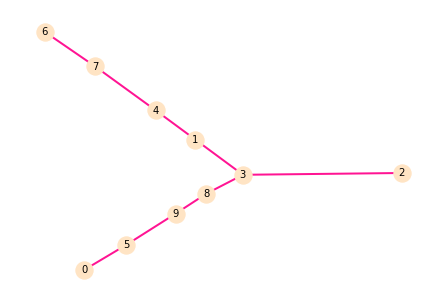

My traversal is df
Neighbors of node 0: ['5']
Neighbors of node 1: ['3', '4']
Neighbors of node 2: ['3']
Neighbors of node 3: ['1', '2', '8']
Neighbors of node 4: ['7', '1']
Neighbors of node 5: ['0', '9']
Neighbors of node 6: ['7']
Neighbors of node 7: ['4', '6']
Neighbors of node 8: ['9', '3']
Neighbors of node 9: ['5', '8']
{'5': '0', '9': '5', '8': '9', '3': '8', '1': '3', '2': '3', '4': '1', '7': '4', '6': '7'}
{'5': '0', '9': '5', '8': '9', '3': '8', '1': '3', '2': '3', '4': '1', '7': '4', '6': '7'}
{'0': '0', '5': '1', '9': '2', '8': '3', '3': '4', '1': '5', '2': '6', '4': '7', '7': '8', '6': '9'}
nr of seqs:
10
new seqs before loop
['aaaaaaaaa', None, None, None, None, None, None, None, None, None]
idx:0, i=0
idx:5, i=1
idx:9, i=2
idx:8, i=3
idx:3, i=4
idx:1, i=5
idx:4, i=6
idx:7, i=7
idx:6, i=8
idx:2, i=9
new s1-index:
7
seqs new:
['aaaaaaaaa', 'aaaaggggg', 'gggggggg', 'ccctttttttt', 'tttttttttt', 'cccccccctttt', 'gggggggggccccccc', 'cctttttttt', 'ccccccccccc', 'ccccccccccccct

In [94]:
score_matrix={'a': {'a': 0, 'c': 5, 'g': 2, 't': 5}, 'c': {'a': 5, 'c': 0, 'g': 5, 't': 2}, 'g': {'a': 2, 'c': 5, 'g': 0, 't': 5}, 't': {'a': 5, 'c': 2, 'g': 5, 't': 0}}
gap_cost=4
total_cost_new, M, matrix_for_MST, visiting_order,graph=new_sp_approxi_combi(doc_seqs,score_matrix,gap_cost,"spring",traversal_here="df")
print("total cost following: ")
print(total_cost_new)
print(M)
print(graph)